In [34]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

In [35]:
#Read the csv file
df = pd.read_csv('/content/GoogleStock.csv')
print(df.head()) #7 columns, including the Date. 


        Date      Open      High       Low     Close  Adj Close     Volume
0  8/20/2004  2.515820  2.716817  2.503118  2.697639   2.697639  458857488
1  8/23/2004  2.758411  2.826406  2.716070  2.724787   2.724787  366857939
2  8/24/2004  2.770615  2.779581  2.579581  2.611960   2.611960  306396159
3  8/25/2004  2.614201  2.689918  2.587302  2.640104   2.640104  184645512
4  8/26/2004  2.613952  2.688672  2.606729  2.687676   2.687676  142572401


In [36]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 


4537   2022-08-29
4538   2022-08-30
4539   2022-08-31
4540   2022-09-01
4541   2022-09-02
4542   2022-09-06
4543   2022-09-07
4544   2022-09-08
4545   2022-09-09
4546   2022-09-12
4547   2022-09-13
4548   2022-09-14
4549   2022-09-15
4550   2022-09-16
4551   2022-09-19
Name: Date, dtype: datetime64[ns]


In [37]:
#Variable for training
col = list(df)[4]
#Date and volume columns are not used in training. 
print(col) 

Close


In [38]:
#New dataframe with only training data - 1 column
df_for_training = df[col].astype(float)
df_for_training

df_for_training.shape

(4552,)

In [39]:
#Feature Scaling or Standardization: It is a step of Data Pre Processing that is applied to independent variables or features of data. It basically helps to normalize the data within a particular range
#StandardScaler is useful for the features that follow a Normal distribution.MinMaxScaler may be used when the upper and lower boundaries are well known from domain knowledge. StandardSCalar changes the shape of data while keeping data into range of 0 and 1. It can eliminate the outliers(which sometimes provides some useful info). NOTE: Do not remove all outliers until you do not have domain knowledge sbout them.If you know you have a fixed min and max in your dataset (e.g. images), you can use min-max scaling to fix your input and/or output data to be between 0 and 1. MinMaxScalar() do not changes the shape of data, while it also keeps the data into range of 0 and 1. It will do it for minimum number of features required.For other applications where you do not have fixed bounds, standard scaling is useful. This gives all of your features zero-mean and unit variance.

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df_for_training_scaled=scaler.fit_transform(np.array(df_for_training).reshape(-1,1))
print(df_for_training_scaled) # we can see that now the closing prices are from 0 to 1.

[[0.00139474]
 [0.0015779 ]
 [0.00081668]
 ...
 [0.68418835]
 [0.68236668]
 [0.68385099]]


In [40]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 1. We will make timesteps = 365 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

In [41]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[0]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape)) 

#In trainX: 4538 refers to the number of data points [total data points aka 4553 - n_future & n_past] and 1 refers to the column

trainX shape == (4538, 14, 1).
trainY shape == (4538, 1).


In [42]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 14, 64)            16896     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
256/256 [==============================] - 13s 31ms/step - loss: 0.0027 - val_loss: 0.0043
Epoch 2/5
256/256 [==============================] - 4s 15ms/step - loss: 8.4143e-04 - val_loss: 0.0014
Epoch 3/5
256/256 [==============================] - 4s 15ms/step - loss: 7.4650e-04 - val_loss: 0.0038
Epoch 4/5
256/256 [==============================] - 7s 27ms/step - loss: 7.0302e-04 - val_loss: 0.0226
Epoch 5/5
256/256 [==============================] - 8s 30ms/step - loss: 6.0885e-04 - val_loss: 0.0026


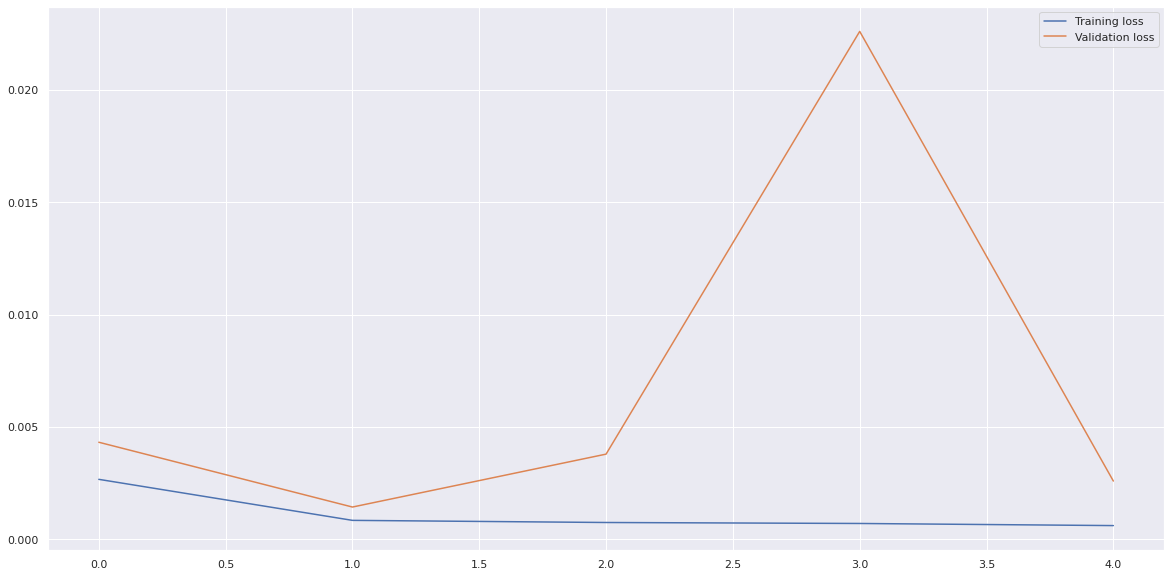

In [43]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [44]:
#Forecasting:

n_future=365
forecast_period_dates= pd.date_range(list(train_dates)[-1],periods=n_future,freq='1d').tolist()

forecast=model.predict(trainX[-n_future:])

12/12 [==============================] - 1s 10ms/step


In [45]:
forecast_copies= np.repeat(forecast,df_for_training.shape[0],axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [46]:
forecast_dates= []
for time_i in forecast_period_dates:
  forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date' :np.array(forecast_dates), 'Close':y_pred_future})
df_forecast['Date']= pd.to_datetime(df_forecast['Date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


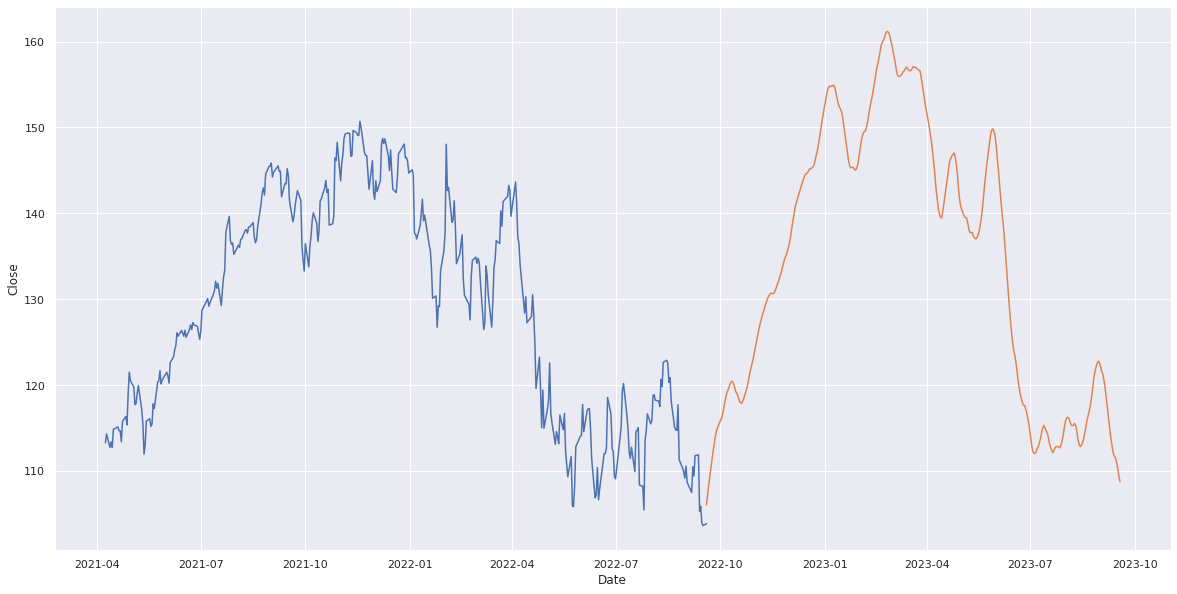

In [47]:
original = df[['Date','Close']]
original['Date']= pd.to_datetime(original['Date'])
original = original.loc [original['Date']>= '2021-4-8']

sns.lineplot(original['Date'], original['Close'])
sns.lineplot(df_forecast['Date'], df_forecast['Close'])

sns.set(rc={'figure.figsize':(20,10)})

In [48]:
df_forecast #this shows the forecasted stock value for the next year

,Date,Close
0,2022-09-19,106.030136
1,2022-09-20,107.236771
2,2022-09-21,108.361481
3,2022-09-22,109.417290
4,2022-09-23,110.386688
...,...,...
360,2023-09-14,111.543121
361,2023-09-15,111.000389
362,2023-09-16,110.333496
363,2023-09-17,109.414162
